In [1]:
%pylab inline
%config InlineBackend.figure_formats = {'svg',}
import seaborn as sns
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
# rc('axes', prop_cycle=cycler('color', flatui))
# sns.palplot(sns.color_palette(flatui))
sns.set(palette=flatui)
rc('svg', fonttype='none')
from qutip import *
from fractions import Fraction
from IPython.display import Markdown

Populating the interactive namespace from numpy and matplotlib


In [27]:
def solve4lme(args):
    #Define atomic states |1>, |2>, |3>, |4>
    st1, st2, st3, st4 = map(lambda st: basis(4, st), range(4))
    
    #Operators for the off-diagonal elements of Hamiltonian
    #Interaction Hamiltonian |1>↔|2> and |2>↔|3>
    #Decay modes(collapse operators)for |2>→|1>, |3>→|2>, |3>→|4>
    sig12 = st1 * st2.dag()  # |1><2|
    sig23 = st2 * st3.dag()  # |2><3|
    sig34 = st3 * st4.dag()  # |3><4|
    
    #Define time dependent collapse operators
    #collapse opertor for 2->1,sqrt(Π21*Γ2) * |2><1|
    C1 = np.sqrt(args['cbr1'] * args['gamma2']) * sig12
     # collapse operator for 3->2, sqrt(Π32*Γ3) * |2><3|
    C2 = np.sqrt(args['cbr2'] * args['gamma3']) * sig23
    # collapse operator for 3->4, sqrt(Π34*Γ3) * |3><4|
    C3 = np.sqrt(args['cbr3'] * args['gamma3']) * sig34
    
    # Define list of collapse operators
    c_op_list = [C1, C2, C3]
    
    #Define time vector
    t = linspace(-arg['tint']*2,arg['tint']*2,101)
    
    #Set up the time independent system Hamiltonians
    #ε1=0, ε2 = w12, ε3=w12+w23, ε4=-w34.
    HS1 = 0
    HS2 = (-args['w12']-args['delta1']) * sig22
    HS3 = (-args['w12']-args['w23']-args['delta2']) * sig33
    HS4 = (-args['w12']-args['w23']+args['w34']) * sig44
    
    #Set up operators for the time varying Hamiltonians
    #for laser-atom interaction Ω12(t) and Ω23(t)
    HI1 = sig12.dag() + sig12
    HI2 = sig23.dag() + sig23
    
    #Set up the time varying RWA Hamiltonians with time dependent
    #coefficients based on QuTip Cython string function format
    HRWA = [HS1,HS2,HS3,HS4,
           [HI1,'hcf12 * exp(-2*(t/tint) **2)'],
           [HI2,'hcf23 * exp(-2*(t/tint) **2)']]
    
    #Define the initial state as state \1>
    psi0 = st1
    
    #Define ODE solver options
    opts = Odeoptions()
    opts.nsteps = args['nsteps']
    
    # Convert Cython string function variable values to numpy.float32
    args['hcf12'] = np.float32(arg['hcf12'])
    args['hcf23'] = np.float32(arg['hcf23'])
    
    #Solve the RWA Hamiltonian
    output = mesolve(HRWA,psi0,t,c_op_list,[sig11,sig22,sig33,sig44],
                    args=args,options=opts,progress_bar=True)
    
    return output
    

In [28]:
def plot4lme(atomdata,results=None,saveplot=None):
    '''Plot QuTiP Result object '''
    
    if results != None:
        rs = results
    else:
        rs = qload(atomdata.filename)
        
    rho11, rho22, rho33 ,rho44 = rs.expect
    timescale = 1e6
    t = rs.times * timescale
    
    #Define pump strength as a function of time for plotting
    wp = lambda t,tw,A: A * np.exp(-2*(t/tw) **2)
    
    # Plot the results
    fig = figure()
    subplot(211)
    if atomdata != None:
        # colors #a6cee3 #2078b4 #afdd8a #35a12e #fa9897 #e31a1c
        detuning = atomdata.delta
        detuning_MHz = detuning/(timescale * 2*pi)
        detuning_MHz_str = str(round(detuning_MHz,2))
        fig.suptitle(atomdata.symbol + ',$τ_{int} = %s$(s),'% str(atomdata.tint) \
                    +'$Δ = &s$(MHz)'%detuning_MHz_str)
        
        ored_sat_24MHz = atomdata.osat / (timescale * 2 * pi *np.sqrt(atomdata.st24))
        ored_sat_24MHz_str = str(round(ored_sat_24MHz,2))
        axhline(y = ored_sat_24_MHz,color='#a6cee3',
                label = '$Ω_{red,sat,24}≈ %s$ MHz'% ored_sat_24_MHz_str)
        
        ored_cr_MHz = atomdata.__class__(atomdata.tint).ocr /(timescale * 2 * pi)
        
        ores_cr_MHz_str = str(round(ored_cr_MHz,2))
        axhline(y=ored_cr_MHz,color='#afdd8a',
               label='$Ω_{red,cr} ≈ %s$ MHz' % ored_cr_MHz_str)
        
        ored_cr_pop_99_MHz = atomdata.__class__(atomdata.tint,pop=99).ocr \
                            /(timescale * 2 *pi) 
        ored_cr_pop_99_MHz_str = str(round(ored_cr_pop_99MHz,2))
        axhine(y = ored_cr_pop_99MHz,color='fa9897',
              label='$Ω_{red,cr}|_{pop=99} ≈ %s$ MHz' % ored_cr_pop_99_MHz_str)
        
    plot(t, wp(t, atomdata.tint * timescale,
               atomdata.hcf23 * 2 / (timescale * 2*pi)), '-', label='$Ω_{23}$')
    plot(t, wp(t, atomdata.tint * timescale,
               atomdata.hcf24 * 2 / (timescale * 2*pi)), '-', label='$Ω_{24}$')
    ylabel('Coupling strength $Ω$ (MHz)')
    lg_1 = legend()
    lg_1.draw_frame(True)
    
    subplot(212)
    plot(t, rho11, '-', label='$ρ_{1,1}$')
    plot(t, rho22, '-', label='$ρ_{2,2}$')
    plot(t, rho33, '-', label='$ρ_{3,3}$')
    plot(t, rho44, '-', label='$ρ_{4,4}$')
    ylabel('Population $ρ$ (rel. units)')
    xlabel('Time ($\mu s$)')
    lg_2 = legend()
    lg_2.draw_frame(True)
    # check if filename for exporting figure is provided
    if saveplot != None:
        savefig(saveplot)
    show()
    
   
        
        
    


In [ ]:
class AtomData4Levels:
    '''Setup parameters for 4-level system RWA Hamiltonian'''
   

In [ ]:
class Hedata:
    symbol = 'He'
    nspin = Fraction(1，2)#nuclear spin
    

In [12]:
st1, st2, st3, st4 = map(lambda st: basis(4, st), range(4))
print(st1 * st2.dag())

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


### 练习qutip


In [1]:
from qutip import*
import numpy as np
import matplotlib.pyplot as plt

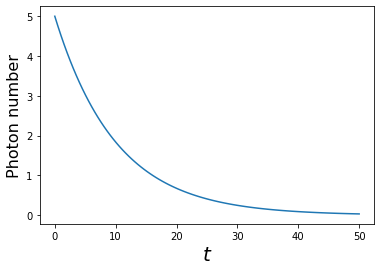

In [85]:
w = 1.0
kappa = 0.1
a = destroy(10)
rho = fock_dm(10,5)
H = w * a.dag() * a

c_ops = [np.sqrt(kappa) * a]
tlist = np.linspace(0,50,100)

result = mesolve(H,rho,tlist,c_ops,[a.dag() * a])



fig, axes = plt.subplots(1,1)
axes.plot(tlist, result.expect[0])
axes.set_xlabel(r'$t$', fontsize=20)
axes.set_ylabel(r"Photon number", fontsize=16);
plt.show()

In [63]:
(a.dag() *a).unit()

Quantum object: dims = [[10], [10]], shape = (10, 10), type = oper, isherm = True
Qobj data =
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.02222222 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.04444444 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.06666667 0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.08888889 0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.11111111
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.13333333 0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.15555556 0.         0.        ]
 [0.         0.         0.         0.     

### J-C Function
考虑一个组合系统在开放系统中的演化过程。量子哈密顿量 ( $J C$ model) 为:
$H_{\mathrm{RWA}}=\hbar \omega_c a^{\dagger} a+\frac{1}{2} \hbar \omega_a \sigma_z+\hbar g\left(a^{\dagger} \sigma_{-}+a \sigma_{+}\right)$
初始态为: $\left|\psi_0\right\rangle=|0\rangle_c \otimes|1\rangle_a$. 注意这里两者存在的系统不同， 代表简谐腔，而a代表构建自旋 量子比特a，为二能级系统。耗散部分分为三部分: (1) 外界热环境导致的光子损失为 $\sqrt{\kappa\left(1+n_{\mathrm{th}}\right)} a ，(2)$ 热环境向谐振腔内产生的光子，为 $\sqrt{\kappa n_{\mathrm{th}}} a^{\dagger} ，(3)$ 原子系统退化率: $\sqrt{\gamma} \sigma_{-}$。Qutip程序为:
https://www.zhihu.com/search?type=content&q=qutip

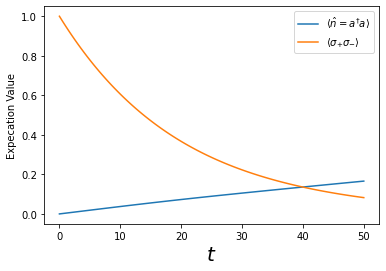

In [93]:


N = 5 # number of cavity states
omega0 = epsilon = 2 * np.pi # frequencies
g = 0.05 * 2 * np.pi # coupling strength
kappa = 0.005 # cavity relaxation rate
gamma = 0.05 # atom relaxation rate
n_th = 0.75 # bath temperature

## Hamiltonian and initial state ##
# destroy() is 湮灭算符，qeye是单位算符

a = tensor(destroy(N), qeye(2))

# sm denotes sigma_minus
sm = tensor(qeye(N), destroy(2))
sz = tensor(qeye(N), sigmaz())
H = omega0 * a.dag() * a + 0.5 * epsilon * sz + g * (a.dag() * sm + a * sm.dag())

psi0 = tensor(fock(N,0), fock(2,1)) # excited atom

## Collapse operators ##
c_ops = []
c_ops.append(np.sqrt(kappa * (1+n_th)) * a)
c_ops.append(np.sqrt(kappa * n_th) * a.dag())
c_ops.append(np.sqrt(gamma) * sm)
## Operator list for expectation values ##
expt_ops = [a.dag() * a, sm.dag() * sm]

## Evolution of the system ##
tlist = np.linspace(0, 50, 100)
expt_data = mesolve(H, psi0, tlist, c_ops, expt_ops)

fig,axes = plt.subplots(1,1)
axes.plot(tlist,expt_data.expect[0],label = r'$\langle \hat{n} = a^\dag a \rangle$')
axes.plot(tlist,expt_data.expect[1],label = r'$\langle\sigma_{+}\sigma_{-}\rangle$')
axes.set_xlabel(r'$t$',fontsize = 20)
axes.set_ylabel("Expecation Value")
axes.legend(loc=1)
plt.show()

In [106]:
a = destroy(5)
a = creator(4)

NameError: name 'creator' is not defined

AttributeError: 'function' object has no attribute 'dag'